## SI671 Final Project
#### Sizhuang He (sizhuang), Yuyuan Ji (jiyuyuan), Yuqing Zhang (zhyuqing)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

### 1. Data Preprocessing

In [2]:
dataset = pd.read_csv('marketing_campaign.csv', sep = '\t')
dataset = dataset.drop(columns = ['Z_CostContact', 'Z_Revenue'], axis = 1)
dataset.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,3,6,5,0,0,0,0,0,0,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Identify number of columns by type
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']
discrete_features = [feature for feature in numerical_features if len(dataset[feature].unique())<25]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
categorical_features = [feature for feature in dataset.columns if feature not in numerical_features]
binary_categorical_features = [feature for feature in categorical_features if len(dataset[feature].unique()) <=3]
print("Numerical Features Count {}".format(len(numerical_features)))
print("Discrete features Count {}".format(len(discrete_features)))
print("Continuous features Count {}".format(len(continuous_features)))
print("Categorical features Count {}".format(len(categorical_features)))
print("Binary Categorical features Count {}".format(len(binary_categorical_features)))

Numerical Features Count 24
Discrete features Count 14
Continuous features Count 10
Categorical features Count 3
Binary Categorical features Count 0


In [6]:
print("Categorical features are: ", categorical_features)

Categorical features are:  ['Education', 'Marital_Status', 'Dt_Customer']


In [7]:
dataset['Marital_Status'].value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [8]:
# Remove and combine some categories in marital status
dataset['Marital_Status'] = dataset['Marital_Status'].replace('Alone', 'Single')
dataset = dataset[(dataset.Marital_Status != 'Absurd') & (dataset.Marital_Status != 'YOLO')]

In [9]:
dataset['Education'].value_counts()

Graduation    1126
PhD            484
Master         369
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [10]:
# Check if there is null data
dataset.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64

In [11]:
# Fill null data with mean values
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
dataset.Income = mean_imputer.fit_transform(dataset[["Income"]])

In [12]:
# Categorize age data into several groups
def getAgeGroup(age):
  ageGroup = ''
  if age <= 18:
    ageGroup = 'Teenager'
  elif age >18 and age<= 30:
    ageGroup = 'Bachelors'
  elif age >30 and age<=50:
    ageGroup  = 'Adults'
  elif age >50 and age<=70:
    ageGroup = 'Seniors'
  elif age>=70 and age<100:
    ageGroup = 'Retired'
  else:
    ageGroup = 'Expired'
  return ageGroup

In [13]:
dataset['Age'] = dataset.apply(lambda row: 2023- int(row.Year_Birth), axis = 1)
dataset['AgeGroup'] = dataset.apply(lambda row: getAgeGroup(row.Age), axis = 1)

In [14]:
dataset.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,AgeGroup
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,1,66,Seniors
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,0,69,Seniors
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,0,58,Seniors
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,0,39,Adults
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,0,42,Adults


In [15]:
dataset.to_csv("preprocessed.csv", index = False)

### 2. Exploratory Data Analysis

#### a. Overview

In [2]:
dataset = pd.read_csv('preprocessed.csv', index_col = False)
dataset.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,AgeGroup
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,1,66,Seniors
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,0,69,Seniors
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,0,58,Seniors
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,0,39,Adults
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,0,42,Adults


In [17]:
dataset.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'AgeGroup'],
      dtype='object')

Here are descriptions of each column in this dataframe:

**People**
|Column Name|Description|
|:-|:-|
|`ID`|Customer's unique identifier|
|`Year_Birth`|Customer's birth year|
|`Education`|Customer's education level|
|`Marital_Status`|Customer's marital status|
|`Income`|Customer's yearly household income|
|`Kidhome`|Number of children in customer's household|
|`Teenhome`|Number of teenagers in customer's household|
|`Dt_Customer`|Date of customer's enrollment with the company|
|`Recency`|Number of days since customer's last purchase|
|`Complain`|1 if the customer complained in the last 2 years, 0 otherwise|
|`Age`|Customer's age|
|`Agegroup`|Customer's age group|

**Products**
|Column Name|Description|
|:-|:-|
|`MntWines`|Amount spent on wine in last 2 years|
|`MntFruits`|Amount spent on fruits in last 2 years|
|`MntMeatProducts`|Amount spent on meat in last 2 years|
|`MntFishProducts`|Amount spent on fish in last 2 years|
|`MntSweetProducts`|Amount spent on sweets in last 2 years|
|`MntGoldProds`|Amount spent on gold in last 2 years|

**Promotions**
|Column Name|Description|
|:-|:-|
|`NumDealsPurchases`|Number of purchases made with a discount|
|`AcceptedCmp[number]`|1 if customer accepted the offer in the [number] campaign, 0 otherwise|
|`Response`|1 if customer accepted the offer in the last campaign, 0 otherwise|

**Channels**
|Column Name|Description|
|:-|:-|
|`NumWebPurchases`|Number of purchases made through the company’s website|
|`NumCatalogPurchases`|Number of purchases made using a catalogue|
|`NumStorePurchases`|Number of purchases made directly in stores|
|`NumWebVisitsMonth`|Number of visits to company’s website in the last month|


In [18]:
dataset[['Year_Birth', 'Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain']].describe()

,Year_Birth,Age,Income,Kidhome,Teenhome,Recency,Complain
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,1968.796512,54.203488,52232.510850,0.444991,0.506261,49.147138,0.009392
std,11.980604,11.980604,25051.855691,0.538551,0.544615,28.954880,0.096477
min,1893.000000,27.000000,1730.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,46.000000,35502.500000,0.000000,0.000000,24.000000,0.000000
50%,1970.000000,53.000000,51741.500000,0.000000,0.000000,49.000000,0.000000
75%,1977.000000,64.000000,68289.750000,1.000000,1.000000,74.000000,0.000000
max,1996.000000,130.000000,666666.000000,2.000000,2.000000,99.000000,1.000000


Here is a numerical overview of **People**:     
The mean of age is 54.   
The mean of yearly household income is 52232.51.    
The mean of days since customer's last purchase is 49.1.    
The mean of complaint rate is quite low, only 0.94%.   

In [19]:
dataset[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
       'MntSweetProducts', 'MntGoldProds']].describe()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,303.873435,26.271020,166.924419,37.405188,27.081395,43.880590
std,336.876776,39.761356,225.778550,54.436749,41.300943,51.979634
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,1.000000,16.000000,3.000000,1.000000,9.000000
50%,173.000000,8.000000,67.000000,12.000000,8.000000,24.000000
75%,505.000000,33.000000,232.000000,50.000000,33.000000,56.000000
max,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000


Here is a numerical overview of **Products**:     
The mean amount spent on wine in last 2 years is 303.9.  
The mean amount spent on fruits in last 2 years is 26.3.  
The mean amount spent on meat in last 2 years is 166.9.   
The mean amount spent on fish in last 2 years is 37.4.    
The mean amount spent on sweet in last 2 years is 27.1.   
The mean amount spent on gold products in last 2 years is 43.9.   

In [20]:
dataset[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Response']].describe()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,0.063953,0.013417,0.072898,0.074687,0.072451,0.148479
std,0.244725,0.115077,0.260027,0.262944,0.259291,0.355654
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Here is a numerical overview of **Promotions**:      
The mean rates for customers to accept the offer in the first 5 campaigns are: 6.4%, 1.3%, 7.3%, 7.5%, 7.2%.     
The mean response rate on the last campaign is 14.8%.   

In [21]:
dataset[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
        'NumStorePurchases', 'NumWebVisitsMonth']].describe()

,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,2.322898,4.082737,2.659213,5.789356,5.317531
std,1.932052,2.779736,2.920752,3.253756,2.424756
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,3.000000,3.000000
50%,2.000000,4.000000,2.000000,5.000000,6.000000
75%,3.000000,6.000000,4.000000,8.000000,7.000000
max,15.000000,27.000000,28.000000,13.000000,20.000000


Here is a numerical overview of **Channels**:     
The mean number of purchases made with a discount is 2.3.  
The mean number of purchases made through the company’s website is 4.1.  
The mean number of purchases made using a catalogue is 2.7.  
The mean number of purchases made directly in stores is 5.8.    
The mean number of visits to company’s website in the last month is 5.3.    

#### b. Purchase pattern analysis accross different categorical groups

In [22]:
dataset.groupby(['Education']).agg(
    {'Income': 'mean' , 'Recency': 'mean', 'Complain': 'mean',
     'MntWines': 'mean', 'MntFruits': 'mean', 
     'MntMeatProducts': 'mean', 'MntFishProducts': 'mean', 
     'MntSweetProducts': 'mean', 'MntGoldProds': 'mean',
     'NumDealsPurchases': 'mean', 'NumWebPurchases': 'mean', 
     'NumCatalogPurchases': 'mean', 'NumStorePurchases': 'mean', 
     'NumWebVisitsMonth': 'mean', 'AcceptedCmp1': 'mean', 
     'AcceptedCmp2': 'mean', 'AcceptedCmp3': 'mean', 
     'AcceptedCmp4': 'mean','AcceptedCmp5': 'mean', 
     'Response': 'mean'}).transpose()

Education,2n Cycle,Basic,Graduation,Master,PhD
Income,47701.160259,20306.259259,52692.052060,52874.188494,56136.765608
Recency,48.418719,48.444444,50.028419,47.585366,48.671488
Complain,0.019704,0.000000,0.012433,0.005420,0.002066
MntWines,198.182266,7.240741,284.103020,333.327913,404.836777
MntFruits,28.955665,11.111111,30.711368,21.531165,20.119835
MntMeatProducts,141.256158,11.444444,179.537300,162.466125,169.092975
MntFishProducts,47.482759,17.055556,43.000000,31.647696,26.822314
MntSweetProducts,34.251232,12.111111,31.341030,21.233062,20.293388
MntGoldProds,46.399015,22.833333,50.676732,40.065041,32.270661
NumDealsPurchases,2.246305,1.796296,2.310835,2.425474,2.363636


After calculating the mean of numerical values across different **education** group, we can get:

PhD group has the highest average income, which is around 56137; Basic group has the lowest average income, which is around 20306.

The numbers of days since customer's last purchase are similar across different groups, and Graduation group has the longest recency around 50.

For complain rate, Basic group has 0% complain rate, and 2n Cycle group has the highest 2.0% complain rate.

For products consumption, Basic group has the lowest spent on all the products. PhD group has the highest spent on wine; Graduation group has the highest spent on fruit, meat, and gold products; 2n Cycle group has the highest spent on fish and sweet.

For purchase channels, the average numbers of deal purchases, web purchases, catalogue purchases, and store purchases are all very similar across all the groups except Basic group. Basic group tends to have lower numbers of purchases. The reason might be they have lower average income. PhD group has the highest average number of web purchases, catalogue purchases, and store purchases. This also aligns with their high average income. Though Basic group makes fewer purchases, they have the highest average number of company's website visits in the past month.

For promotions, Basic group has very low accepting/response rate on campaigns except the third campaign. PhD group generally has a relatively higher accepting/response rate on campaigns. 


In [23]:
dataset.groupby(['Marital_Status']).agg(
    {'Income': 'mean' , 'Recency': 'mean', 'Complain': 'mean',
     'MntWines': 'mean', 'MntFruits': 'mean', 
     'MntMeatProducts': 'mean', 'MntFishProducts': 'mean', 
     'MntSweetProducts': 'mean', 'MntGoldProds': 'mean',
     'NumDealsPurchases': 'mean', 'NumWebPurchases': 'mean', 
     'NumCatalogPurchases': 'mean', 'NumStorePurchases': 'mean', 
     'NumWebVisitsMonth': 'mean', 'AcceptedCmp1': 'mean', 
     'AcceptedCmp2': 'mean', 'AcceptedCmp3': 'mean', 
     'AcceptedCmp4': 'mean','AcceptedCmp5': 'mean', 
     'Response': 'mean'}).transpose()

Marital_Status,Divorced,Married,Single,Together,Widow
Income,52834.228448,51729.090944,50973.643059,53233.307890,56426.370271
Recency,49.487069,48.277778,49.387164,50.106897,49.142857
Complain,0.008621,0.009259,0.012422,0.008621,0.000000
MntWines,324.844828,299.480324,287.687371,306.825862,369.272727
MntFruits,27.426724,25.734954,26.693582,25.350000,33.090909
MntMeatProducts,150.206897,160.681713,181.140787,168.103448,189.285714
MntFishProducts,35.043103,35.380787,38.026915,38.991379,51.389610
MntSweetProducts,26.818966,26.701389,27.136646,26.122414,39.012987
MntGoldProds,46.288793,42.822917,43.625259,42.994828,56.766234
NumDealsPurchases,2.435345,2.392361,2.140787,2.324138,2.337662


After calculating the mean of numerical values across different **marital status** group, we can get:

Widow group has the highest average yearly household income, which is around 56426; Single group has the lowest average yearly household income, which is around 50974.

The numbers of days since customer's last purchase are similar across different groups, and Together group has the longest recency around 50.

For complain rate, Widow group has 0% complain rate, and Single group has the highest 1.2% complain rate.

For products consumption, Widow group has the highest spent on all the products and the amounts are much higher than other groups. Single group has the lowest spent on wine; Together group has the lowest spent on fruit and sweet; Divorced group has the lowest spent on meat and fish. Married group has the lowest spent on gold products.

For purchase channels, Single group tends to have lower numbers of purchases, regardless of the channel. The reason might be they have lower average income. Divorced group has the highest average number of deal purchases. Widow group has the highest average number of web purchases, catalogue purchases, and store purchases. This also aligns with their high average income. But Widow group makes the fewest visits to the company's website compared to other groups.

For promotions, Divorced group has higher accepting rate on campaign 2 and 3. Widow group has extremly high accepting rate on campaign 4 and 5 as well as the response rate on the last campaign. 

In [24]:
dataset.groupby(['AgeGroup']).agg(
    {'Income': 'mean' , 'Recency': 'mean', 'Complain': 'mean',
     'MntWines': 'mean', 'MntFruits': 'mean', 
     'MntMeatProducts': 'mean', 'MntFishProducts': 'mean', 
     'MntSweetProducts': 'mean', 'MntGoldProds': 'mean',
     'NumDealsPurchases': 'mean', 'NumWebPurchases': 'mean', 
     'NumCatalogPurchases': 'mean', 'NumStorePurchases': 'mean', 
     'NumWebVisitsMonth': 'mean', 'AcceptedCmp1': 'mean', 
     'AcceptedCmp2': 'mean', 'AcceptedCmp3': 'mean', 
     'AcceptedCmp4': 'mean','AcceptedCmp5': 'mean', 
     'Response': 'mean'}).transpose()


AgeGroup,Adults,Bachelors,Expired,Retired,Seniors
Income,48078.000096,62457.785714,60118.000000,59125.086674,54074.468775
Recency,48.728982,47.785714,52.666667,48.571429,49.626384
Complain,0.009956,0.071429,0.333333,0.012987,0.006458
MntWines,240.860619,349.000000,259.333333,392.199134,337.141144
MntFruits,24.590708,39.071429,50.000000,29.541126,26.744465
MntMeatProducts,156.411504,357.285714,191.666667,202.510823,165.581181
MntFishProducts,34.560841,85.285714,39.333333,44.424242,37.657749
MntSweetProducts,25.977876,45.000000,22.666667,30.367965,27.082103
MntGoldProds,39.314159,56.928571,83.666667,51.883117,45.704797
NumDealsPurchases,2.169248,1.142857,1.000000,2.060606,2.525830


After calculating the mean of numerical values across different **age** group, we can get:

Bachelors group has the highest average yearly household income, which is around 62458; Adults group has the lowest average yearly household income, which is around 48078.

The numbers of days since customer's last purchase are similar across different groups except Expired group. The average numbers of days since customer's last purchase of Expired group is the longest, which is 52.7.

For complain rate, Seniors group has the lowest 0.6% complain rate, and Expired group has the highest 33.3% complain rate. But this might be due to the number of people in Expired group is small. Except that, Bachelors group has the highest 7.1% complain rate.

For products consumption, Bachelors group has the highest spent on meat, fish, and sweet, and the amounts are much higher than other groups. Retired group has the highest spent on wine, and Expired group has the highest spent on fruit and gold products. Adults group has the lowest spent on all products except sweet. This might be related to their low income. Expired group has the lowest spent on sweet.

For purchase channels, Expired group tends to have lower numbers of purchases, regardless of the channel. Seniors group has the highest average number of deal purchases. Retired group has the highest average number of web purchases and store purchases. Bachelors group has the highest average number of catalogue purchases. Adults group makes the most visits to the company's website compared to other groups.

For promotions, Bachelors group has higher accepting rate on campaigns while Expired group has very low accepting rate.

#### c. Visualizations

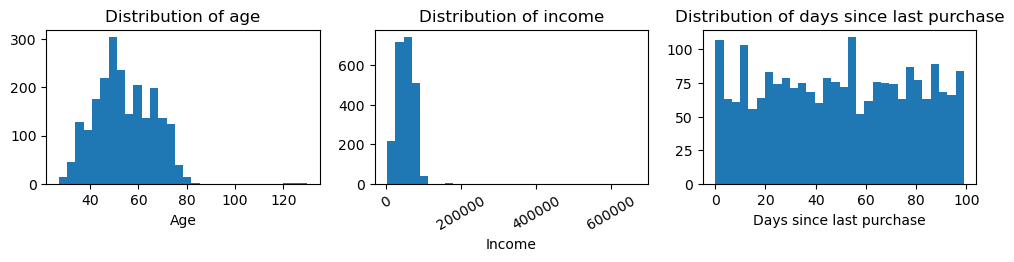

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 2))
ax1.hist(dataset['Age'], bins = 30)
ax1.set_title('Distribution of age')
ax1.set_xlabel('Age')

ax2.hist(dataset['Income'], bins = 30)
ax2.set_title('Distribution of income')
ax2.set_xlabel('Income')
ax2.tick_params(axis = 'x', labelrotation = 30)

ax3.hist(dataset['Recency'], bins = 30)
ax3.set_title('Distribution of days since last purchase')
ax3.set_xlabel('Days since last purchase')

plt.show()

The distributions of age and income are right skewed and have several outliers on the right.

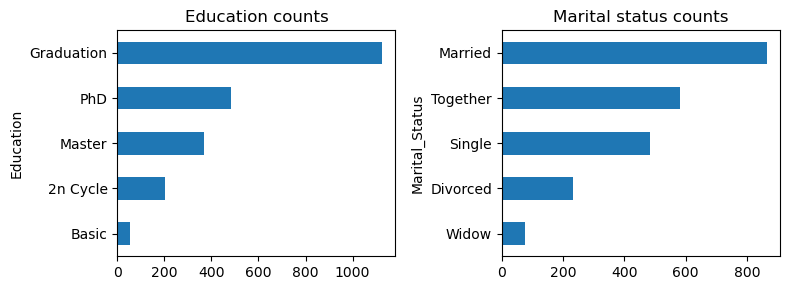

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3))

dataset.groupby('Education').size().sort_values(ascending=True).plot(kind = 'barh', ax = ax1)
ax1.set_title('Education counts')

dataset.groupby('Marital_Status').size().sort_values(ascending=True).plot(kind = 'barh', ax = ax2)
ax2.set_title('Marital status counts')

plt.tight_layout()
plt.show()

The majority of the customers are graduated from colleges and in a married or together relation.

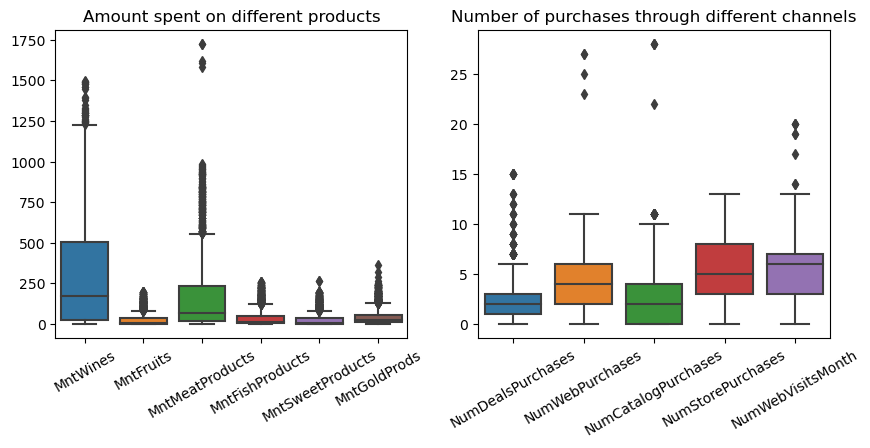

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
sns.boxplot(data = dataset[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                            'MntSweetProducts', 'MntGoldProds']], ax = ax1)
ax1.tick_params(axis = 'x', labelrotation = 30)
ax1.set_title('Amount spent on different products')

sns.boxplot(data = dataset[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
                            'NumStorePurchases', 'NumWebVisitsMonth']], ax = ax2)
ax2.tick_params(axis = 'x', labelrotation = 30)
ax2.set_title('Number of purchases through different channels')

plt.show()

Comparing to other products, customers spent more on wines and meat.    
The most popular way of purchase is in-store purchase. However, web purchase and catalog purchase have several outliers, meaning some customers are keen on these channels.    

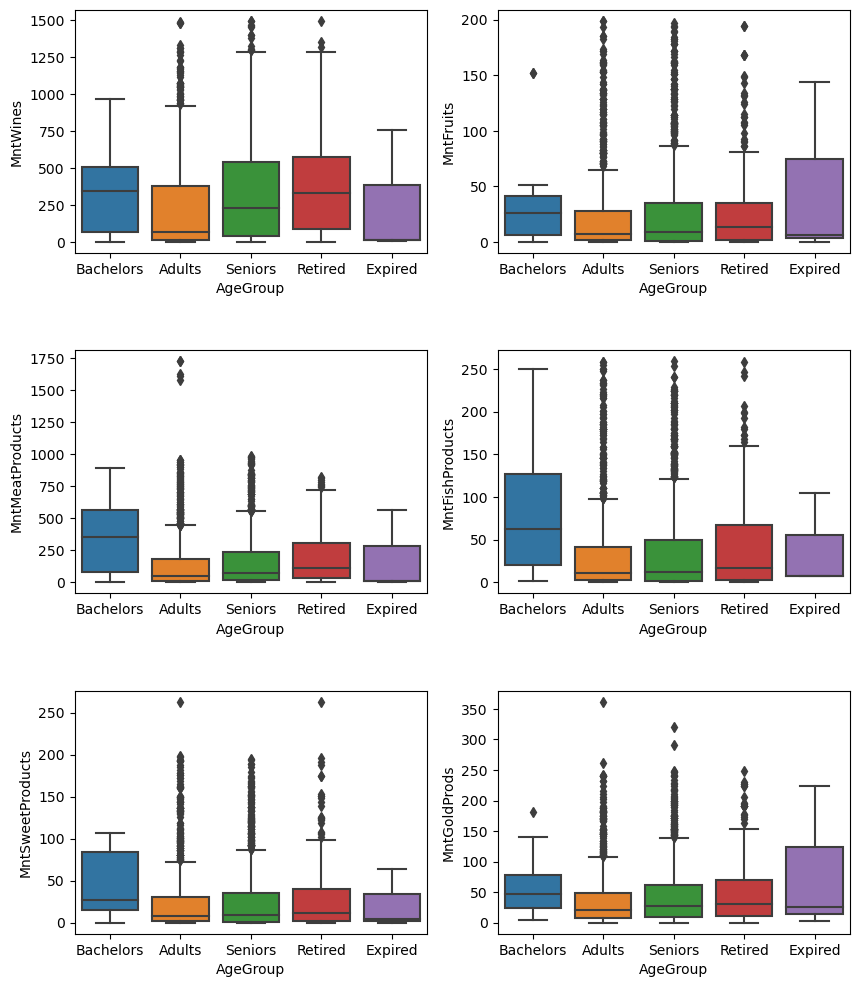

In [28]:
fig, axes = plt.subplots(3, 2, figsize = (10, 12))
age_order = ['Bachelors', 'Adults', 'Seniors', 'Retired', 'Expired']
ax1 = sns.boxplot(x = 'AgeGroup',y = 'MntWines', data = dataset, ax = axes[0, 0], order = age_order)
ax2 = sns.boxplot(x = 'AgeGroup',y = 'MntFruits', data = dataset, ax = axes[0, 1], order = age_order)
ax3 = sns.boxplot(x = 'AgeGroup',y = 'MntMeatProducts', data = dataset, ax = axes[1, 0], order = age_order)
ax4 = sns.boxplot(x = 'AgeGroup',y = 'MntFishProducts', data = dataset, ax = axes[1, 1], order = age_order)
ax5 = sns.boxplot(x = 'AgeGroup',y = 'MntSweetProducts', data = dataset, ax = axes[2, 0], order = age_order)
ax6 = sns.boxplot(x = 'AgeGroup',y = 'MntGoldProds', data = dataset, ax = axes[2, 1], order = age_order)

plt.subplots_adjust(hspace = 0.4) 
plt.show()

Age groups have different product preferences. The bachelors spent more on every categories comparing to other age groups. The adults, seniors, and retired have similar purchase patterns.

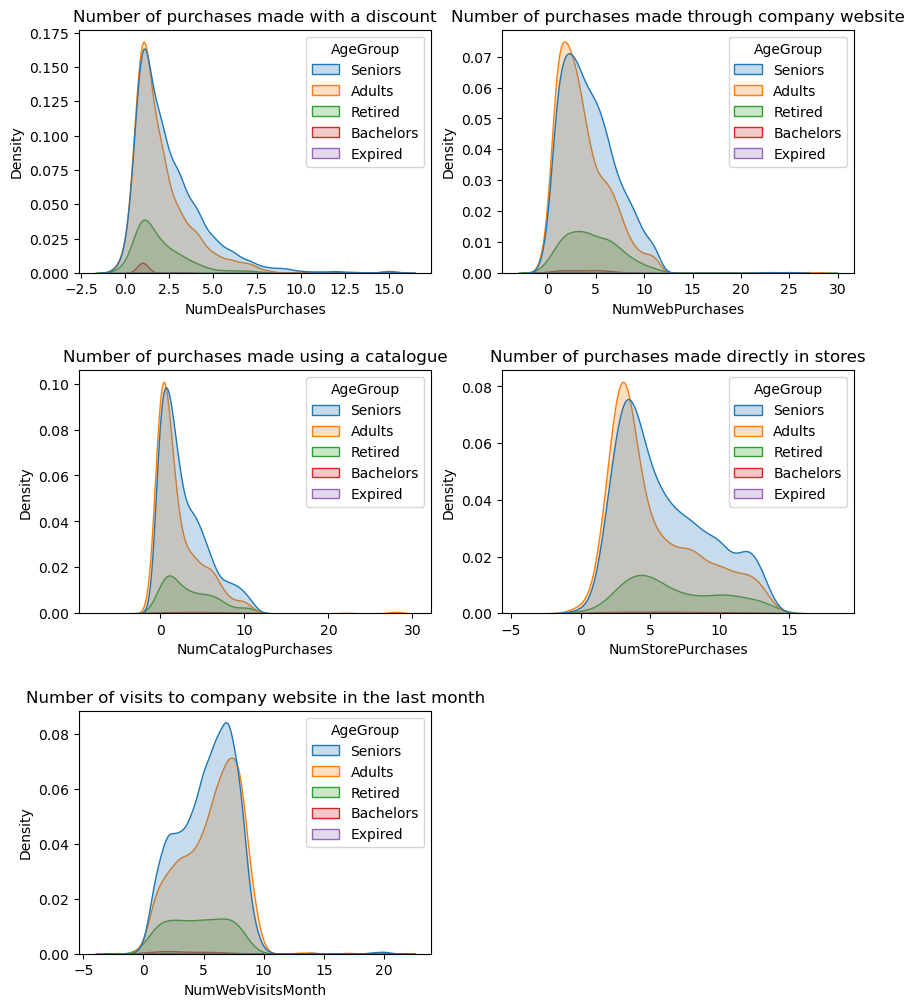

In [29]:
fig, axes = plt.subplots(3, 2, figsize = (10, 12))

ax1 = sns.kdeplot(data = dataset, x = 'NumDealsPurchases', hue = 'AgeGroup', fill = True, ax = axes[0, 0])
ax1.set_title("Number of purchases made with a discount")

ax2 = sns.kdeplot(data = dataset, x = 'NumWebPurchases', hue = 'AgeGroup', fill = True, ax = axes[0, 1])
ax2.set_title("Number of purchases made through company website")

ax3 = sns.kdeplot(data = dataset, x = 'NumCatalogPurchases', hue = 'AgeGroup', fill = True, ax = axes[1, 0])
ax3.set_title("Number of purchases made using a catalogue")

ax4 = sns.kdeplot(data = dataset, x = 'NumStorePurchases', hue = 'AgeGroup', fill = True, ax = axes[1, 1])
ax4.set_title("Number of purchases made directly in stores")

ax5 = sns.kdeplot(data = dataset, x = 'NumWebVisitsMonth', hue = 'AgeGroup', fill = True, ax = axes[2, 0])
ax5.set_title("Number of visits to company website in the last month")

axes[2,1].set_visible(False)

plt.subplots_adjust(hspace = 0.4)
plt.show()

We plot the kde plots with different colors representing different age groups. From the 5 kde plots, there is no obvious diffenrence in shopping channels for different age groups.

#### c. Correlation

In [30]:
dataset_corr = dataset[['Age', 'Income', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]

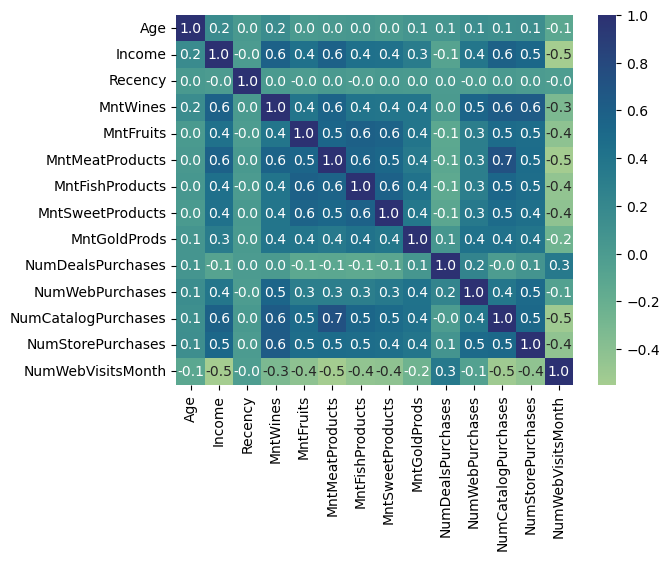

In [31]:
sns.heatmap(dataset_corr.corr(), annot = True, fmt=".1f", cmap = 'crest')
plt.show()

From the heatmap, it can be observed that the strongest positive correlation occurs between the number of catalog purchases and amount spent on meat products. The correlation between household income and the amount spent on wines and meat is also quite strong.

### 3. Preparation for Model Development

In [2]:
dataset = pd.read_csv('preprocessed.csv', index_col = False)
dataset.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,AgeGroup
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,1,66,Seniors
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,0,69,Seniors
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,0,58,Seniors
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,0,39,Adults
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,0,42,Adults


#### a. Encoding categorical attributes

In [3]:
# Transform part of the categorical features into dummies
dataset = pd.get_dummies(dataset, columns=['Education', 'Marital_Status', 'AgeGroup']) 

In [4]:
dataset.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,AgeGroup_Adults,AgeGroup_Bachelors,AgeGroup_Expired,AgeGroup_Retired,AgeGroup_Seniors
0,5524,1957,58138.0,0,0,04-09-2012,58,635,88,546,...,0,0,1,0,0,0,0,0,0,1
1,2174,1954,46344.0,1,1,08-03-2014,38,11,1,6,...,0,0,1,0,0,0,0,0,0,1
2,4141,1965,71613.0,0,0,21-08-2013,26,426,49,127,...,0,0,0,1,0,0,0,0,0,1
3,6182,1984,26646.0,1,0,10-02-2014,26,11,4,20,...,0,0,0,1,0,1,0,0,0,0
4,5324,1981,58293.0,1,0,19-01-2014,94,173,43,118,...,0,1,0,0,0,1,0,0,0,0


#### b. Combinig product categories

In [5]:
dataset['TotalMntSpent'] = dataset['MntWines'] + dataset['MntFruits'] + dataset['MntMeatProducts'] \
                         + dataset['MntFishProducts'] + dataset['MntSweetProducts'] + dataset['MntGoldProds']

In [6]:
dataset = dataset.drop(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                        'MntSweetProducts', 'MntGoldProds'], axis = 1)

#### c. Train-test split

In [7]:
# add a new column `accept_offer` to represent whether a customer has ever accepted an offer
# used as labels for classification problem

def accept_offer(record):
    accept = 0
    if 1 in record:
        accept = 1
    return accept

dataset['accept_offer'] = dataset.apply(lambda row:
                                        accept_offer([row.AcceptedCmp1,
                                                      row.AcceptedCmp2,
                                                      row.AcceptedCmp3,
                                                      row.AcceptedCmp4,
                                                      row.AcceptedCmp5,
                                                      row.Response]), 
                                        axis = 1)

In [8]:
X = dataset.drop(['ID', 'Year_Birth', 'Dt_Customer', 
                  'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
                  'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'accept_offer', 'TotalMntSpent'], axis=1)

# y_amount: regression problem
# y_offer: classification problem
y_amount = dataset['TotalMntSpent']
y_offer = dataset['accept_offer']

In [9]:
X_train, X_test, y_amount_train, y_amount_test, y_offer_train, \
y_offer_test = train_test_split(X, y_amount, y_offer, test_size = 0.3, random_state = 42)

### 4. Regression

#### a. Feature selection

In [10]:
# Feature selection based on mutual information
sel_k_cols = SelectKBest(mutual_info_regression, k = 10)
sel_k_cols.fit(X_train, y_amount_train)

selected_indices = sel_k_cols.get_support(indices = True)
selected_features = X_train.columns[selected_indices]
print("Selected Features based on Mutual Information Scores:", selected_features)

Selected Features based on Mutual Information Scores: Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Age'],
      dtype='object')


Based on the results of F-test and mutual information, we select the following features: 
`Income`, `Kidhome`, `Teenhome`, `Recency`, `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `NumWebVisitsMonth`, `Age`.

In [11]:
# Keep only the selected columns in the DataFrame
X_train_reg = X_train[selected_features].copy() 
X_test_reg = X_test[selected_features].copy() 

#### b. Scaling

In [12]:
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

#### c. Model selection

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR(),
    "KNN Regression": KNeighborsRegressor()
}

for name, model in models.items():
    model.fit(X_train_reg_scaled, y_amount_train)
    y_amount_pred = model.predict(X_test_reg_scaled)
    MSE = mean_squared_error(y_amount_test, y_amount_pred)
    R2 = r2_score(y_amount_test, y_amount_pred)
    print(f"{name} - Mean Squared Error: {MSE}")
    print(f"{name} - R^2 Score: {R2}")
    print("\t")

Linear Regression - Mean Squared Error: 80965.76286356991
Linear Regression - R^2 Score: 0.7644910081256717
	
Lasso Regression - Mean Squared Error: 80902.82282843582
Lasso Regression - R^2 Score: 0.7646740848200511
	
Ridge Regression - Mean Squared Error: 80957.96161198687
Ridge Regression - R^2 Score: 0.7645136999997515
	
Decision Tree - Mean Squared Error: 93940.25484351713
Decision Tree - R^2 Score: 0.7267514819579539
	
Random Forest - Mean Squared Error: 47647.054926378536
Random Forest - R^2 Score: 0.8614067295283755
	
Gradient Boosting - Mean Squared Error: 48511.2435789043
Gradient Boosting - R^2 Score: 0.858893022608964
	
Support Vector Regression - Mean Squared Error: 270156.0177077496
Support Vector Regression - R^2 Score: 0.21418425357957527
	
KNN Regression - Mean Squared Error: 66090.2742175857
KNN Regression - R^2 Score: 0.8077600543342149
	


Based on the MSE and R^2 results for all models, I will select the Random Forest Regressor model.

#### d. Parameter selection & prediction

In [15]:
# Define the parameter grid to search
param_dist = {
    'n_estimators': randint(100, 1000),  
    'max_depth': randint(3, 15),        
    'min_samples_split': randint(2, 20), 
    'min_samples_leaf': randint(1, 10),  
    'max_features': [1.0, 'sqrt'] 
}

# Find best parameters
rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, \
                                n_iter = 100, cv = 5, random_state = 42, n_jobs = -1)
random_search.fit(X_train_reg_scaled, y_amount_train)
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

In [16]:
# Predict using best parameters
y_amount_pred = best_estimator.predict(X_test_reg_scaled)
MSE = mean_squared_error(y_amount_test, y_amount_pred)
R2 = r2_score(y_amount_test, y_amount_pred)

print(f"Best parameters: {best_params}")
print(f"Mean Squared Error: {MSE}")
print(f"R^2 Score: {R2}")

Best parameters: {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 996}
Mean Squared Error: 42756.85911109965
R^2 Score: 0.8756310762867086


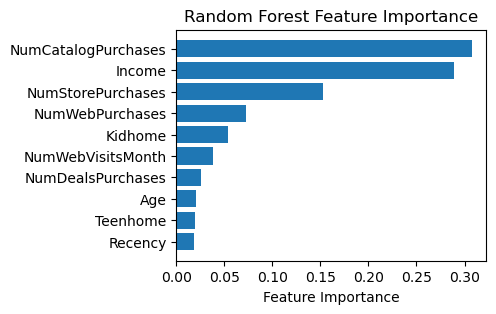

In [23]:
# Compute feature importance
feature_importance = best_estimator.feature_importances_
feature_names = X_train_reg.columns

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize = (4, 3))
plt.barh(range(len(sorted_importance)), sorted_importance, align = 'center')
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

Based on the results of feature importance, the number of in-store purchases and income are important features in prediction.

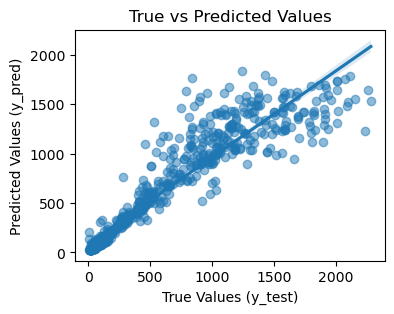

In [24]:
plt.figure(figsize = (4, 3))
sns.regplot(x = y_amount_test, y = y_amount_pred, scatter_kws = {'alpha':0.5})
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('True vs Predicted Values')
plt.show()